# <center> TP 2.2 - Etats de marché
---
---
> Buts du TP : les buts de ce TP sont d'utiliser l'algorithme de Louvain pour la détermination d'états de marché, puis de au choix :
  - réaliser une stratégie basée sur les états de marchés, 
  - utiliser le ML/DL pour prédire la direction d'un titre financier

---
# 1 - Détermination d'états de marché

## 1) Les données

- Les données représente $981$ différentes actions US pour $1929$ pas de temps
- On choit d'enlever les outliers (rendement supérierurs ou inférieurs à 1)
- On décide de remplacer les np.inf et d'interpoler afin de ne supprimer aucunes lignes et de garder l'echelle de jours à la suite

In [ ]:
!pip install python-louvain
from numpy import linalg as LA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import community
from tqdm.notebook import tqdm
plt.style.use("ggplot")

In [ ]:
# Import de nos drive pour les fichiers
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks Centrale/Physique des marchés/TP 2.2 - Markets State/us_equities.csv.gz").iloc[1:,:] # Pour supprimer la premiere ligne qui est que en NaN
data.drop(["Unnamed: 0"],axis=1, inplace=True)
data.head()

,^GSPC,GE,IBM,DIS,BA,CAT,AA,HPQ,DD,KO,XOM,PG,JNJ,CVX,MCD,MRK,UTX,MMM,MO,HON,ED,GT,AEP,FL,MRO,DTE,IP,CNP,NAV,WMT,BMY,BP,LMT,C,KR,AET,XRX,F,DOW,PEP,...,SKM,CCJ,FFG,GES,WG,TD,FMS,ANF,HMY,SKS,OCN,CHH,NCI,PAG,NOV,NVS,TGI,IM,PDS,ING,NUS,CNI,PSS,DB,CIG,NCR,CVD,MWW,TIE,LVB,CNH,MIL,ABV,STL,SOV,SGR,LIZ,ABK,CAE,TKS
1,-0.002163,-0.001119,-0.003239,0.004155,-0.012491,0.021665,0.000000,-0.004006,-0.008623,-0.004700,-0.012511,-0.002522,-0.002740,0.000971,-0.011489,-0.014401,-0.007463,0.002955,0.014583,-0.006835,-0.002684,-0.004240,0.000823,-0.025411,0.016543,0.003889,0.000799,0.014423,0.025796,-0.004024,-0.006486,-0.007186,-0.001408,0.001904,0.000000,-0.011905,0.039149,0.002212,-0.001503,-0.002950,...,0.013634,-0.013305,-0.009620,-0.012327,-0.018275,0.000650,0.001693,-0.033023,-0.001427,0.010018,-0.016787,0.005736,-0.309045,0.007267,-0.000474,-0.002189,0.003984,-0.011734,-0.024762,-0.002104,0.002107,-0.010753,0.002801,-0.009474,0.006757,-0.001144,0.000670,-0.007741,-0.015534,-0.010785,0.000000,-0.017828,0.002717,-0.008307,0.000000,0.0,0.009009,0.00000,0.009346,0.077626
2,0.005240,-0.000374,0.001702,0.005379,0.010006,0.008942,-0.011192,0.015083,0.000900,-0.005313,0.030277,-0.002068,0.005495,0.021581,-0.008494,-0.008676,-0.002734,-0.005074,0.007187,0.000344,-0.004373,0.007097,0.003289,-0.001022,0.026037,-0.000968,-0.015176,-0.001185,0.026389,0.005303,0.000593,0.018818,0.008058,-0.001481,0.004082,0.029335,-0.005733,-0.006623,-0.007227,0.000455,...,-0.008795,0.003236,0.011563,-0.010920,0.011169,-0.005198,0.000845,0.019615,0.002857,0.012624,0.000000,0.000475,0.056970,0.012266,0.030332,0.001097,0.002834,-0.009235,0.029297,0.006326,0.009464,-0.020186,0.010056,0.012255,-0.033557,-0.004007,0.004461,0.005319,0.031558,0.003759,0.002076,-0.011551,0.029810,0.015707,0.000000,0.0,0.101190,0.00000,-0.002315,-0.050847
3,-0.002348,-0.004111,-0.002163,-0.001235,-0.007103,-0.004305,0.004789,0.032194,0.019479,0.006528,-0.001042,-0.008061,-0.003708,0.004985,0.018936,0.001382,-0.009367,-0.005100,-0.001019,0.006880,0.003041,0.000000,-0.005738,0.002559,0.000000,0.001292,0.004461,0.000000,0.036600,0.003266,-0.002966,-0.000474,-0.000799,-0.000841,-0.008808,-0.016539,0.009885,0.031111,0.004550,0.000455,...,-0.005741,0.025269,-0.014175,-0.007886,-0.002209,0.001306,-0.007601,0.001202,0.076923,0.038290,-0.026829,-0.007126,0.012041,-0.008553,-0.004140,-0.015886,-0.001696,-0.007989,0.003163,-0.011316,-0.002604,0.003170,0.003872,-0.001034,0.034722,-0.009195,0.004886,0.004233,0.045889,-0.011610,0.000000,0.021703,0.018421,-0.012371,-0.008929,0.0,-0.007508,0.00000,0.004640,0.040179
4,0.002262,-0.002251,0.003716,0.008653,-0.000377,0.005849,0.011265,0.020154,-0.008230,-0.001769,0.001043,-0.008126,-0.000196,-0.004960,-0.014159,0.005060,0.004843,0.003968,-0.002041,-0.008200,-0.000674,-0.000705,0.002061,0.002042,-0.003172,0.002904,0.010900,0.007117,0.001459,0.006259,0.013087,0.003791,-0.008800,-0.000841,-0.007519,0.018370,0.026917,0.018319,0.009058,0.000682,...,0.000000,0.000524,-0.001855,0.007949,0.006642,-0.005871,0.015319,-0.008063,0.005291,-0.001715,-0.017544,-0.014833,-0.007932,0.020848,0.015704,-0.000557,-0.015289,-0.016107,-0.006936,-0.003391,0.001567,0.004739,0.011570,-0.008720,0.026846,0.006381,0.021657,-0.006322,0.032907,0.009473,-0.001381,0.009804,0.025840,-0.017745,-0.054054,0.0,0.002421,-0.03125,-0.006928,-0.012876
5,0.002573,-0.003761,-0.002005,-0.004085,-0.026365,0.010114,-0.004713,-0.001411,0.001482,0.003544,0.001876,0.001639,0.001763,0.002136,0.006284,0.007323,0.004131,0.007411,-0.020450,0.020668,0.007078,0.001410,0.010695,0.020886,0.005569,0.003861,0.021965,0.005889,-0.001748,0.028863,0.005285,0.005192,-0.001816,-0.003987,0.011708,0.006352,-0.006354,0.028571,0.013465,-0.000227,...,0.001575,0.014675,0.017193,0.058360,0.026393,0.000000,0.024308,0.029747,-0.022368,0.025773,0.033163,0.007771,0.019417,0.011972,-0.004093,-0.002506,0.025877,0.012960,-0.002540,-0.005955,0.030240,-0.014937,0.046296,0.000895,0.026144,-0.013256,0.019035,-0.001414,-0.005310,0.009760,-0.006224,

In [ ]:
# On supprime les colonnes ou des Nan sont présents
data = data.replace([np.inf, -np.inf], np.nan)
data.dropna(axis=1, inplace=True)

# On supprime les outliers
outliers = []
for i in range(len(list(data.columns))):
  if min(data.iloc[:,:].values[:,i]) < -1 or max(data.iloc[:,:].values[:,i]) > 1:
    outliers.append(data.columns[i])
outliers

['VHI', 'FOE', 'DIN', 'FGP', 'HIG']

In [ ]:
data.drop(columns=outliers, inplace=True) #(1929, 947)

- Il nous reste donc 947 actifs au total

## 2) Fenetre de calibration $T$

- Nous prenons une fenêtre de calibration de $T=250$

In [ ]:
T = 250

## 3) Univers de titres
- Nous décidons de prendre $750$ titres (les $750$ premiers) afin d'avoir $T = N/3$. 

In [ ]:
univers = data.iloc[:,:750]

## 4) Appliquer l'algorithme de Louvain

### Code fourni pour l'algorithme de Louvain

- Pour déterminer les états de marchés nous allons utilsier l'algorithme de Louvain. 
  - C'est un algorithme d'apprentissage non supérvisé qui ne requiert pas de fixer en input le nombre d'états. 
  - Il se divise en deux parties : une phase d'optimisation de la modularité et une phase d'aggrégation de communautées.
  - Ces deux etapes se deroulent de maniére itérative jusqu'a qu'il n'y ai plus de changement dans le systéme et que le maximum sur la modularité soit atteint.

  - Il crée un ensemble inital de points et un ensemble initial d'arêtes qui forment un graphe non orienté $G = (V_{0},E_{0})$ avec $V_{0}$ les vertex initiaux et $E_{0}$ les arêtes initiales.

  - Il traite chaque point l'un après l'autre en le changeant de communauté pour maximiser la modularité et s'arrête une fois que la modularité est maximale.

  - Lors de l'aggregation , l'ensemble des neouds appartenants à une meme comunautée sont fusionnés en un seul noeud plus grand 

- On rappelle qu'on doit avoir $N>T$ pour les états de marchés et $T>N$ pour le clustering de titres. Nous devons donc avoir $N>T$ dans notre cas.

In [ ]:
def compute_C_minus_C0(lambdas,v,lambda_plus):
    N=len(lambdas)
    C_clean=np.zeros((N, N))
    
    v_m=np.matrix(v)
    # _s stands for _structure below
    for i in range(N-1):
        if lambdas[i]>lambda_plus:
            C_clean=C_clean+lambdas[i] * np.dot(v_m[i,].T,v_m[i,]) 
    return C_clean    
    
def LouvainCorrelationClustering(R):   # R is a matrix of return
    N=R.shape[1]
    T=R.shape[0]

    q=N*1./T
    lambda_plus=(1.+np.sqrt(q))**2

    C=R.corr()
    lambdas, v = LA.eigh(C)
    
    C_s=compute_C_minus_C0(lambdas,v,lambda_plus)
    C_s=np.abs(C_s)
    
    mygraph= nx.from_numpy_matrix(np.abs(C_s))
    partition = community.community_louvain.best_partition(mygraph)

    DF=pd.DataFrame.from_dict(partition,orient="index")
    return(DF)

## 5) Nombre d'états de marchés en fonction du temps

- Pour notre taille de fenetre de calibration et pour nos $750$ assets, nous allons tracer le nombre d'états de marché avec la fenêtre de calibration glissante afin de montrer que le nombre d'états de marchés est stable au cours du temps

In [ ]:
T=250
nb_mkt_states=[]
for i in tqdm(range(univers.shape[0]-T+1)):
    universtemp = univers.loc[i:(i+T),:].T
    days_clusters = LouvainCorrelationClustering(universtemp)
    nb_mkt_states.append(len(np.unique(days_clusters.values)))

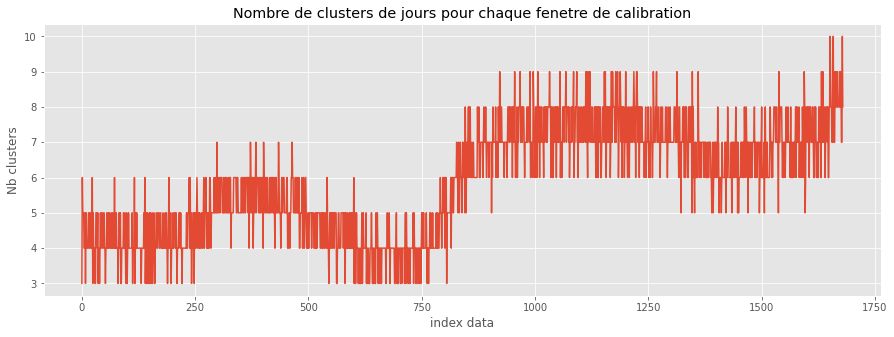

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set(title="Nombre de clusters de jours pour chaque fenetre de calibration", ylabel="Nb clusters", xlabel="index data")
ax.plot(nb_mkt_states);

- Nous voyons donc que nous avons entre $3$ et $10$ états de marché sur toutes nos fenetres de calbration. Nous pouvons donc conclure que la méthode de Louvain est très stable.

# 6) Etats qui ne varient pas au cours du temps

- Typiquement, si on ne veut pas que le nombre d'états varie au cours du temps. Nous devons faire de la classification supervisée. Mais cela recquiert de connaitre les états à l'avance.

---
#2) Stratégies basées sur les états de marché

- On applique les questions 1), 2) et 3) ensembles ici.

- Nous prenons les $947$ actifs pour définir les états de marché.

- Notre stratégie va se baser sur le long et le short d'un actif conditionnellement au dernier état de marché de la fenêtre temporelle.
  - C'est à dire que, connaissant le dernier état de marché de notre fenêtre, nous allons sélectionner l'état de marché qui apparait le plus souvent juste après ceux égaux au dernier de notre fenêtre,
  - Pour cet état, on calcule conditionnellement la moyenne des rendements de chaque actif,
  - On trie ces rendements,
  - On décide de shorter les 5 derniers assets associés et d'être long sur les 5 premiers pour le pas suivant (notre stratégie est donc à un pas)
  - On répète sur chaque fenêtre glissante (100 fenêtres au total et taille de fenêtre de $T=250$).

In [ ]:
def asset_selection(states,returns_wdw):
  """ Méthode nous permettant de sélectionner le meilleur et le moins bon des assets sur la période sélectionnée"""
  # On prend les index des états juste après ceux égaux au dernier
  ind = np.where(states.values == states.values[-1])[0] + 1
  # On remove le dernier car il correspond à notre dernier jour
  ind = ind[:-1] 
  # On sélectionne ces états
  l = states.loc[ind].values.reshape(1,-1).tolist()[0]
  # On compte le nombre d'apparaitions des états
  list_count = [[x,l.count(x)] for x in set(l)]
  # On trie de manière décroissante en fonction de l'apparition
  list_count.sort(key=lambda x: x[1], reverse=True)
  # On selectionne le plus courant
  next_state = list_count[0][0]
  # On selectionne les index d'apparition de cet état
  index_next = np.array(np.where(states.values == next_state)[0])
  # On filtre notre data de returns seulement sur cet état
  returns_wdw = returns_wdw.iloc[index_next]
  # On sélectionne les 5 meilleurs assets de notre fenetre et les 5 pires
  best_asset_wdw = list(returns_wdw.mean(axis=0).sort_values(ascending=False).index[:5])
  worst_asset_wdw = list(returns_wdw.mean(axis=0).sort_values(ascending=False).index[-5:])
  return best_asset_wdw, worst_asset_wdw

In [ ]:
def strat_Mkt_state(data, nb_windows, wdw):
  # Notre dataframe d'asset à long/shorter
 asset_signal = pd.DataFrame( ["rowtobeinpos", "asset_long", "asset_short"])
 for i in tqdm(range(nb_windows)): # on le fait avec 100 fenetres de calibrations
  # On selectionne notre partie de returns
  returns_wdw = data.iloc[i:(i+wdw)]
  # On définit les états de marché sur ces returns
  states = LouvainCorrelationClustering(returns_wdw.T)
  # on utilise la fonction afin de selectionner nos assets
  best_asset_wdw, worst_asset_wdw = asset_selection(states, returns_wdw)
  # on les ajoute a notre dataframe, avec la ligne correspondant au pas de temps ou on tiendra la position
  asset_signal = asset_signal.append({'rowtobeinpos' : i+wdw , 'asset_long' : best_asset_wdw, 'asset_short' : worst_asset_wdw}, ignore_index=True)
 return asset_signal

In [ ]:
asset_signal = strat_Mkt_state(data, 100, T)

- Voici les assets a avoir en portefeuille et à shorter pour les $5$ premiers et derniers pas de temps
  - "rowtobeinpos" respecte l'indexation $0$ 

In [ ]:
asset_signal

,rowtobeinpos,asset_long,asset_short
0,250,"[SGU, DRL, NRT, UFI, GFI]","[NL, GCH, POT, CIA, REV]"
1,251,"[NEU, AEM, CAS, SWC, AKS]","[OI, RSH, HOV, BTH, REV]"
2,252,"[TIE, MDR, SWN, HMY, CBZ]","[HOV, CMO, BXG, BTH, LXK]"
3,253,"[SGU, TIE, PNK, MIL, HPQ]","[DHI, TOL, TDW, HOV, CYD]"
4,254,"[NEU, TIE, MTZ, PSS, AEM]","[REV, NR, KWK, RSH, NL]"
...,...,...,...
95,345,"[GEO, AOI, BID, AP, MIG]","[GFI, ZQK, DLX, SPF, LM]"
96,346,"[SGU, ELN, AKS, AGN, AEM]","[RYL, NVR, CQB, CHS, REV]"
97,347,"[AEM, VMI, AP, GES, KGC]","[LUB, HOV, KNX, UAM, CQB]"
98,348,"[ELN, GRA, GEO, NEU, PKE]","[MEI, NL, DRL, LUB, CYD]"


In [ ]:
def compute_strat_returns(data, asset_signal, nb_windows):
 ret = np.zeros(nb_windows)
 for i in range(nb_windows):
      ind = asset_signal['rowtobeinpos'][i]
      best =  asset_signal['asset_long'][i]
      worst = asset_signal['asset_short'][i]
      ret[i] = 0.5*np.average(data[best].iloc[ind].values) - 0.5*np.average(data[worst].iloc[ind].values)
 return ret

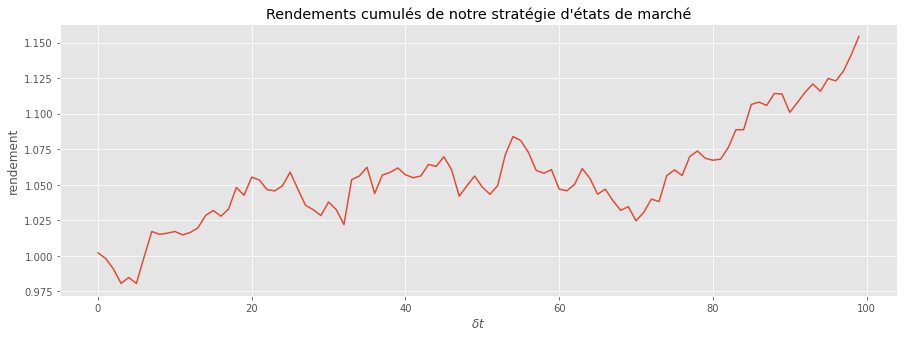

In [ ]:
ret = compute_strat_returns(data, asset_signal, 100)
# On plot les rendements cumulés
retcum = (1+ret).cumprod()
retcum
# On plt les rendements cumulés
fig, ax = plt.subplots(figsize=(15,5))
ax.set(title="Rendements cumulés sur les $100$ premières données", xlabel="$\delta t$", ylabel="rendement")
ax.plot(retcum);

- Mais vérifions quand même sur une autre partie du dataset, après les $1000$ premières lignes par exemple.

In [ ]:
asset_signal_2 = strat_Mkt_state(data.iloc[1000:], 100, T)

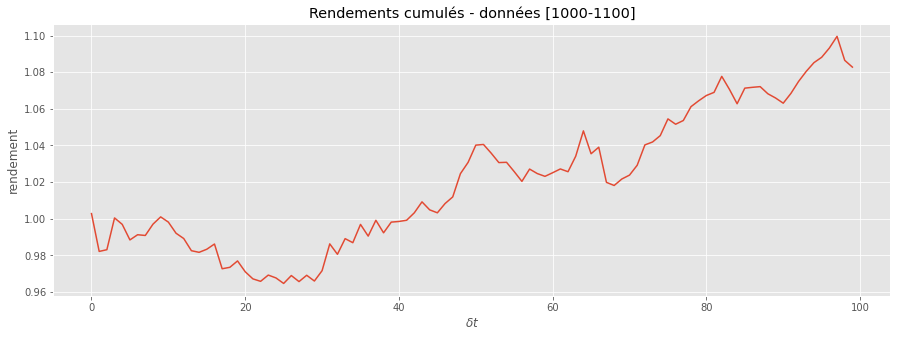

In [ ]:
ret2 = compute_strat_returns(data, asset_signal_2, 100)
retcum2 = (1+ret2).cumprod()
retcum2
fig, ax = plt.subplots(figsize=(15,5))
ax.set(title="Rendements cumulés - données [1000-1100]", xlabel="$\delta t$", ylabel="rendement")
ax.plot(retcum2);

- Nous voyons que la stratégie est également profitable, cela est satisfaisant, mais ne veut biensur pas dire qu'elle sera profitable tout le temps et pour tous les paramètres.

---
# 3 - Prédiction de la direction d'un titre 

- Ici nous allons utiliser des méthodes de ML/DL pour prédire le signe du rendement futur d'un titre financier de notre choix. 

- Nous allons essayer de fitter les données avec un ANN, puis avec un Random Forest.

## ANN

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [ ]:
R_signtopredict = np.sign(data["IBM"])
t0 = 0
t1 = 1500

In [ ]:
# Avec un seul Louvain sur t0;t1
K = 30
X_train = []
Y_train = []
for i in range(K, len(days_clusters)):
  X_train.append(days_clusters.values[(i-K):i,0])
  Y_train.append(R_signtopredict.iloc[i])
X_train = np.array(X_train)
Y_train = np.array(Y_train)
# On eneleve la derniere ligne qui nous servira pour la prediction
to_predict = X_train[-1,:]
X_train = X_train[:-1,:]
real_last_ret = Y_train[-1]
Y_train = Y_train[:-1]
# On met les valeus -1 de Y_train à 0 pour n'avoir que des 0 1s
Y_train[Y_train==-1] = 0

In [ ]:
# Avec un louvain pour chaque ligne de la matrice P
K = 30
X_train = []
Y_train = []
for i in tqdm(range(K, t1)):
  datatemp = data.iloc[(i-K):i,:].T
  days_clusters = LouvainCorrelationClustering(datatemp)
  X_train.append(days_clusters.values.reshape(1,-1)[0])
  Y_train.append(R_signtopredict.iloc[i])
X_train = np.array(X_train)
Y_train = np.array(Y_train)
# On eneleve la derniere ligne qui nous servira pour la prediction
to_predict = X_train[-1,:]
X_train = X_train[:-1,:]
real_last_ret = Y_train[-1]
Y_train = Y_train[:-1]
# On met les valeus -1 de Y_train à 0 pour n'avoir que des 0 1
Y_train[Y_train==-1] = 0

In [ ]:
X_train = pd.DataFrame(X_train)

In [ ]:
# One Hot encoding des variables catégoriques
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

X_train = pd.DataFrame(X_train)

preprocess = make_column_transformer(
        (OneHotEncoder(), X_train.columns),
        remainder="passthrough")
X = preprocess.fit_transform(X_train)
to_predict = preprocess.transform(to_predict.reshape(1,-1))

In [ ]:
X = X.toarray() # a commenter quand X n'est pas retourné en sparse array
X.shape

(1469, 316)

In [ ]:
Y_train.shape

(1469,)

In [ ]:
# On initialise
classifieur = Sequential()

classifieur.add(Dense(units = 30, activation = "tanh", input_dim = X.shape[1]))
# classifieur.add(Dropout(rate = 0.2))
classifieur.add(Dense(units = 30, activation = "tanh"))
# classifieur.add(Dropout(rate = 0.2))
classifieur.add(Dense(units = 30, activation = "tanh"))
classifieur.add(Dropout(rate = 0.2))
classifieur.add(Dense(units = 20, activation = "tanh"))
classifieur.add(Dropout(rate = 0.2))
classifieur.add(Dense(units = 20, activation = "tanh"))
# classifieur.add(Dropout(rate = 0.2))
classifieur.add(Dense(units = 20, activation = "tanh")) # Dernière couche donc on ne met pas le return_sequencies
# classifieur.add(Dropout(rate = 0.2))

# On rajoute la couche de sortie
classifieur.add(Dense(units=1, activation="sigmoid")) # on ne précise pas l'activation, donc ca va être "linéaire" par défaut. Mais on peut aussi mettre "ReLU" !
# On compile 
classifieur.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
# classifieur.fit(X, Y_train, epochs=100, validation_split=0.1, batch_size=10, callbacks=[es])
classifieur.fit(X, Y_train, epochs=100, validation_split=0.2, batch_size=10)

Epoch 1/100
118/118 [==============================] - 1s 5ms/step - loss: 0.7067 - accuracy: 0.4886 - val_loss: 0.6899 - val_accuracy: 0.5374
Epoch 2/100
118/118 [==============================] - 0s 3ms/step - loss: 0.6918 - accuracy: 0.5201 - val_loss: 0.6857 - val_accuracy: 0.5408
Epoch 3/100
118/118 [==============================] - 0s 3ms/step - loss: 0.6839 - accuracy: 0.5838 - val_loss: 0.6847 - val_accuracy: 0.5408
Epoch 4/100
118/118 [==============================] - 0s 3ms/step - loss: 0.6718 - accuracy: 0.5818 - val_loss: 0.6916 - val_accuracy: 0.5510
Epoch 5/100
118/118 [==============================] - 0s 3ms/step - loss: 0.6645 - accuracy: 0.6261 - val_loss: 0.6920 - val_accuracy: 0.5510
Epoch 6/100
118/118 [==============================] - 0s 3ms/step - loss: 0.6578 - accuracy: 0.6359 - val_loss: 0.6999 - val_accuracy: 0.5340
Epoch 7/100
118/118 [==============================] - 0s 3ms/step - loss: 0.6446 - accuracy: 0.6316 - val_loss: 0.7051 - val_accuracy: 0.5544

- Ainsi nous voyons que l'accuracy du validation splot n'est jamais concluante, toujours aux alentoures de $0.5$. Après de multiples tentatives de changement d'architecture, l'accuracy restait vers $0.5$. Nous ne souhaitons donc pas utiliser l'ANN dans une stratégie de prédiction du signe des rendements.

- On note que l'accuracy sur le train set augmente mais pas celle du validation set, significatif de l'Overfitting. Apres avoir essayé d'ajouter des couches DropOut, cela n'a pas été concluant non plus.

- De plus, la méthode de construction de $P$ avec un seul Louvain ou un pour chaque ligne ($K$ éléments) nous donnait les mêmes résultats.

## XGBoost

In [ ]:
# Cross-validation (sklearn propose une instance de XGBoost pour cross-valider)
import xgboost as xgb
def xval_xgboost(xtrain):
  xg_reg = xgb.XGBClassifier(objective ='binary:logistic', learning_rate = 0.3, max_depth = 6, n_estimators = 600, eta=0.1)
  scores = cross_val_score(xg_reg, X, Y_train, cv=10)
  print(scores.mean())

xval_xgboost(X_train)

0.48538346845587554


- Nous voyons que pour le modèle XGBoost, nous sommes confronté à la même absence de pouvoir predictif.

In [ ]:
# # Modèle XGBoost 
# dtrain = xgb.DMatrix(data=X, label=Y_train)
# dtest = xgb.DMatrix(to_predict)
# param = {
#     'max_depth': 6,  # maximum depth de chaque arbre
#     'eta': 0.1,  # training step pour chaque iteration
#     # 'silent': 0,  # Run sans print
#     'objective': 'binary:logistic',  # Pour le multiclass
#     'learning_rate': 0.1} 
# num_round = 600  # Nomre d'itérations (comme le nombre d'arbres d'un Random Forest)

# bst = xgb.train(param, dtrain, num_round)

In [ ]:
# # Prédiction
# preds = bst.predict(dtest)

# predict = np.asarray([np.argmax(line) for line in preds])